In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge, SGDRegressor, PassiveAggressiveRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Set seed for reproducibility
np.random.seed(42)

In [2]:
# Re-load the dataset (user needs to re-upload the file)
df = pd.read_csv(f"../data/Top_12_German_Companies_Financial_Data.csv") # Load the dataset

# Filter dataset for SAP SE only
sap_df = df[df["Company"] == "SAP SE"].copy()

# Convert Period column to datetime format
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")

# Sort data by Period for proper time-series analysis
sap_df = sap_df.sort_values(by="Period").set_index("Period")

# Convert revenue to numeric
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")
sap_df= sap_df[["Revenue"]]

<Axes: title={'center': 'SAP SE Revenue Over Time'}, xlabel='Period'>

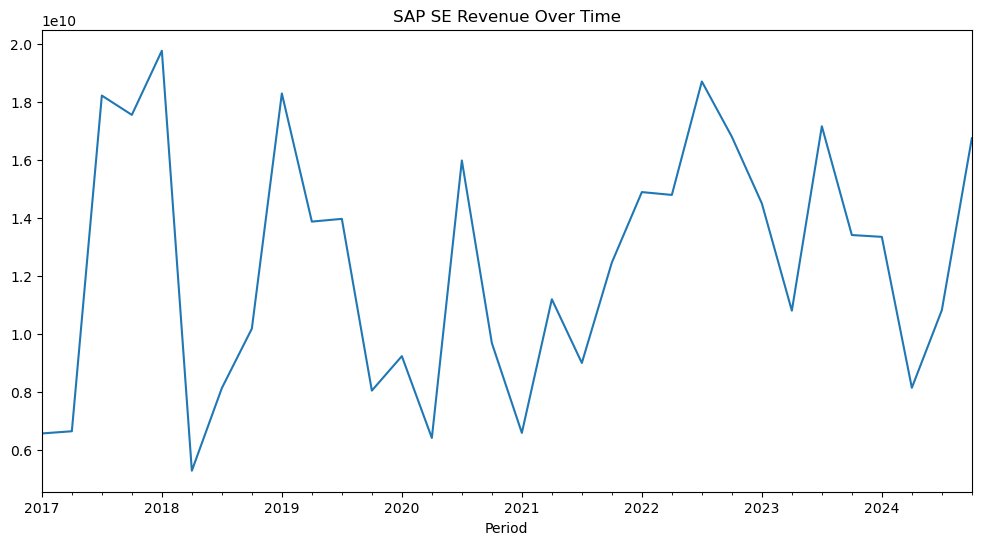

In [3]:
sap_df["Revenue"].plot(figsize=(12, 6), title="SAP SE Revenue Over Time")

In [4]:
sap_df.head()

,Revenue
Period,
2017-03-31,6568715630
2017-06-30,6644029236
2017-09-30,18227487487
2017-12-31,17560385805
2018-03-31,19774628627


In [5]:
# Function to create lagged features
def create_lagged_features(df, target_col, lags):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Define forecasting parameters
lags = 12  # Use 12 months of lagged revenue
duration = 3  # Predict next 6 months

# Generate lagged features
sap_df = create_lagged_features(sap_df, 'Revenue', lags)

# Create multiple target variables for multi-step forecasting
for i in range(1, duration + 1):
    sap_df[f'Revenue_t+{i}'] = sap_df['Revenue'].shift(-i)

sap_df = sap_df.dropna()


In [6]:
# Train-test split (80% train, 20% test)
test_size = int(len(sap_df) * 0.2)
train, test = sap_df.iloc[:-test_size], sap_df.iloc[-test_size:]

In [7]:
sap_df.head()

,Revenue,Revenue_lag1,Revenue_lag2,Revenue_lag3,Revenue_lag4,Revenue_lag5,Revenue_lag6,Revenue_lag7,Revenue_lag8,Revenue_lag9,Revenue_lag10,Revenue_lag11,Revenue_lag12,Revenue_t+1,Revenue_t+2,Revenue_t+3
Period,,,,,,,,,,,,,,,,
2020-03-31,9236017256,8.046709e+09,1.397315e+10,1.387829e+10,1.830075e+10,1.018433e+10,8.133296e+09,5.282345e+09,1.977463e+10,1.756039e+10,1.822749e+10,6.644029e+09,6.568716e+09,6.413036e+09,1.598673e+10,9.687560e+09
2020-06-30,6413035553,9.236017e+09,8.046709e+09,1.397315e+10,1.387829e+10,1.830075e+10,1.018433e+10,8.133296e+09,5.282345e+09,1.977463e+10,1.756039e+10,1.822749e+10,6.644029e+09,1.598673e+10,9.687560e+09,6.588278e+09
2020-09-30,15986728775,6.413036e+09,9.236017e+09,8.046709e+09,1.397315e+10,1.387829e+10,1.830075e+10,1.018433e+10,8.133296e+09,5.282345e+09,1.977463e+10,1.756039e+10,1.822749e+10,9.687560e+09,6.588278e+09,1.119919e+10
2020-12-31,9687560178,1.598673e+10,6.413036e+09,9.236017e+09,8.046709e+09,1.397315e+10,1.387829e+10,1.830075e+10,1.018433e+10,8.133296e+09,5.282345e+09,1.977463e+10,1.756039e+10,6.588278e+09,1.119919e+10,9.000668e+09
2021-03-31,6588278496,9.687560e+09,1.598673e+10,6.413036e+09,9.236017e+09,8.046709e+09,1.397315e+10,1.387829e+10,1.830075e+10,1.018433e+10,8.133296e+09,5.282345e+09,1.977463e+10,1.119919e+10,9.000668e+09,1.246523e+10


In [8]:
# Define X (features) and y (targets)
X_train = train.drop(columns=["Revenue"] + [f'Revenue_t+{i}' for i in range(1, duration + 1)])
y_train = train[[f'Revenue_t+{i}' for i in range(1, duration + 1)]]
X_test = test.drop(columns=["Revenue"] + [f'Revenue_t+{i}' for i in range(1, duration + 1)])
y_test = test[[f'Revenue_t+{i}' for i in range(1, duration + 1)]]

In [9]:
# Define multi-output models and hyperparameters
models = {
    "MultiOutput(GradientBoosting)": MultiOutputRegressor(GradientBoostingRegressor()),
    "MultiOutput(RandomForest)": MultiOutputRegressor(RandomForestRegressor()),
    "MultiOutput(AdaBoost)": MultiOutputRegressor(AdaBoostRegressor()),
    "MultiOutput(Bagging)": MultiOutputRegressor(BaggingRegressor()),
    "MultiOutput(ExtraTrees)": MultiOutputRegressor(ExtraTreesRegressor()),
    "MultiOutput(DecisionTree)": MultiOutputRegressor(DecisionTreeRegressor()),
    "MultiOutput(Ridge)": MultiOutputRegressor(Ridge()),
    "MultiOutput(Lasso)": MultiOutputRegressor(Lasso()),
    "MultiOutput(ElasticNet)": MultiOutputRegressor(ElasticNet()),
    "MultiOutput(HuberRegressor)": MultiOutputRegressor(HuberRegressor()),
    "MultiOutput(BayesianRidge)": MultiOutputRegressor(BayesianRidge()),
    "MultiOutput(SGDRegressor)": MultiOutputRegressor(SGDRegressor()),
    "MultiOutput(PassiveAggressiveRegressor)": MultiOutputRegressor(PassiveAggressiveRegressor()),
    "MultiOutput(XGBoost)": MultiOutputRegressor(XGBRegressor()),
    # "MultiOutput(LightGBM)": MultiOutputRegressor(LGBMRegressor()),
    # "MultiOutput(CatBoost)": MultiOutputRegressor(CatBoostRegressor(verbose=0)),
    "MultiOutput(MLPRegressor)": MultiOutputRegressor(MLPRegressor(max_iter=1000)),
    "MultiOutput(SVR)": MultiOutputRegressor(SVR())
}

# Hyperparameter grid search
param_grid = {
    "MultiOutput(GradientBoosting)": {"estimator__n_estimators": [100, 200], "estimator__learning_rate": [0.01, 0.1], "estimator__max_depth": [3, 5]},
    "MultiOutput(RandomForest)": {"estimator__n_estimators": [100, 200], "estimator__max_depth": [3, 5]},
    "MultiOutput(AdaBoost)": {"estimator__n_estimators": [50, 100], "estimator__learning_rate": [0.01, 0.1]},
    "MultiOutput(Bagging)": {"estimator__n_estimators": [50, 100]},
    "MultiOutput(ExtraTrees)": {"estimator__n_estimators": [100, 200], "estimator__max_depth": [3, 5]},
    "MultiOutput(XGBoost)": {"estimator__n_estimators": [100, 200], "estimator__learning_rate": [0.01, 0.1], "estimator__max_depth": [3, 5]},
    "MultiOutput(LightGBM)": {"estimator__n_estimators": [100, 200], "estimator__learning_rate": [0.01, 0.1], "estimator__max_depth": [3, 5]},
    "MultiOutput(CatBoost)": {"estimator__iterations": [100, 200], "estimator__learning_rate": [0.01, 0.1]}
}

In [10]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train and evaluate models
results = []
for model_name, model in models.items():
    print(f"Training {model_name} with Grid Search...")
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=tscv, scoring='neg_mean_absolute_error', verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mase = mae / mean_absolute_error(y_train.iloc[1:], y_train.iloc[:-1])

    results.append({
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R²": r2,
        "MASE": mase,
        "Best Params": grid_search.best_params_ if model_name in param_grid else None
    })

Training MultiOutput(GradientBoosting) with Grid Search...
Training MultiOutput(RandomForest) with Grid Search...
Training MultiOutput(AdaBoost) with Grid Search...
Training MultiOutput(Bagging) with Grid Search...
Training MultiOutput(ExtraTrees) with Grid Search...
Training MultiOutput(DecisionTree) with Grid Search...
Training MultiOutput(Ridge) with Grid Search...
Training MultiOutput(Lasso) with Grid Search...
Training MultiOutput(ElasticNet) with Grid Search...
Training MultiOutput(HuberRegressor) with Grid Search...
Training MultiOutput(BayesianRidge) with Grid Search...
Training MultiOutput(SGDRegressor) with Grid Search...
Training MultiOutput(PassiveAggressiveRegressor) with Grid Search...
Training MultiOutput(XGBoost) with Grid Search...


/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.633e+19, tolerance: 2.017e+16
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+16, tolerance: 1.579e+16
  model = cd_fast.enet_coordinate_descent(
/opt/conda/envs/ai_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Training MultiOutput(MLPRegressor) with Grid Search...
Training MultiOutput(SVR) with Grid Search...


In [11]:
# Convert results to DataFrame and sort by best performance
results_df = pd.DataFrame(results).sort_values(by="R²").reset_index(drop=True)
results_df.head()

,Model,MAE,RMSE,MAPE,R²,MASE,Best Params
0,MultiOutput(SGDRegressor),1.576210e+30,1.785960e+30,1.434838e+20,-4.773673e+41,4.657185e+20,None
1,MultiOutput(Ridge),1.689151e+10,1.950303e+10,1.626900e+00,-6.707568e+01,4.990886e+00,None
2,MultiOutput(ElasticNet),1.689150e+10,1.950303e+10,1.626900e+00,-6.707566e+01,4.990885e+00,None
3,MultiOutput(Lasso),1.689150e+10,1.950303e+10,1.626900e+00,-6.707566e+01,4.990885e+00,None
4,MultiOutput(HuberRegressor),4.408564e+09,5.451525e+09,3.954398e-01,-2.910063e+00,1.302586e+00,None
